In [34]:
goph_root="D:\\Python_code\\LHY_homework\\hw11\\Goph"
faces_root="D:\\Python_code\\LHY_homework\\hw11\\faces"

In [71]:
import glob
import os
import cv2
import torch
import torchvision.transforms as transforms
a=glob.glob(os.path.join(goph_root,'*'))

In [89]:
a

['D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498172676.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498178518.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498203824.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498208536.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498214694.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498238749.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498246111.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498252433.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498260727.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498265253.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498279380.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498285742.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498292665.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498298699.png',
 'D:\\Python_code\\LHY_homework\\hw11\\Goph\\1445498303541.png',
 'D:\\Python_code\\LHY_ho

In [93]:
cv2.imshow("sk",dataset[0])

error: OpenCV(4.5.2) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


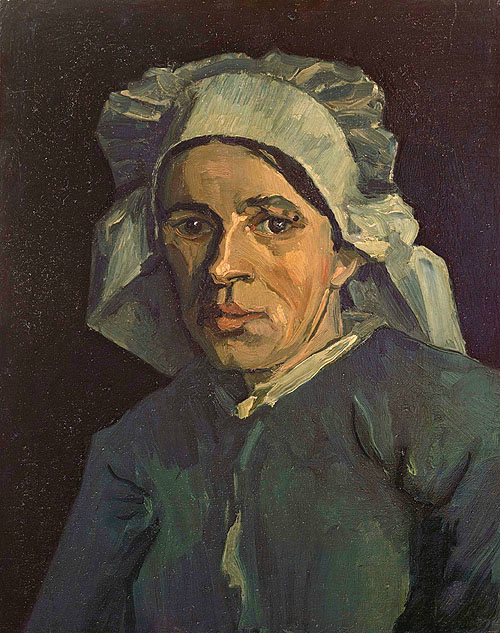

In [16]:
from PIL import Image
Image.open(a[2])

# Dataset

In [90]:
from torch.utils.data import Dataset,DataLoader
import cv2

class Img_dataset(Dataset):
    def __init__(self,img_list,transforms=None):
        self.img_list=img_list
        self.transform=transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img_root=self.img_list[idx]
        x=cv2.imread(img_root)
        if self.transform is not None:
            x=self.transform(x)
        return x

In [91]:
transform = transforms.Compose([transforms.ToPILImage(),
         transforms.Resize((128, 128)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3) ]
        )

dataset=Img_dataset(a,transforms=transform)
dataloader=DataLoader(dataset,batch_size=16,shuffle=True)

# Model

# 逆卷积

这是在stride=1的情况下：

    New_padding=kernel-padding-1

    New_h=in_h+2*New_padding

    out_h=(New_h -  kernel + 2 * padding)/stride + 1

    化简结果：
        (in_h + kernel -2 )/stride + 1

希望能够把内容和画风分离

In [75]:
import torch.nn as nn

class Auto_encoder(nn.Module):
    def __init__(self):
        
        ##     input size :torch.Size([50, 3, 64, 64])
        ##     
        super(Auto_encoder,self).__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(3,64,3,1,1),  #           [batchsize,3,32,32]
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64,128,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128,256,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256,512,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2),   #[batch_size,512,1,1]
        )
        
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(512,256,5,stride=1),   
            #[batchsize,256,5,5]
            nn.ReLU(),
            
            nn.ConvTranspose2d(256,128,10,stride=1),
            #[batchsize,128,14,14]
            nn.ReLU(),
            
            nn.ConvTranspose2d(128,64,14,stride=1),
            #[batchsize,64,27,27]
            nn.ReLU(),
            
            nn.ConvTranspose2d(64,3,6,stride=1),
            #[batchsize,3,32,32]
            nn.ReLU(),
        )
        
    def forward(self,x):
        embedding=self.encoder(x)
        re_img=self.decoder(embedding)
        return embedding,re_img
    
class Discriminator(nn.Module):
    def __init__(self):
        self.fc=nn.Sequential(
            nn.Conv2d(3,64),
        )
    
    def forward(self,x):
        pass

In [79]:
from torch import optim

batch_num=10
lr=0.001

model=Auto_encoder()
optimizer=optim.Adam(model.parameters(),lr=lr)
criterion=nn.MSELoss()


for epoch in range(batch_num):
    for data in dataloader:

        embedding,re_img=model(data)
        loss=criterion(data,re_img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(r"epoch:{} loss:{:.2f}".format(epoch+1,loss))
torch.save(model,"D:\\Python_code\\LHY_homework\\hw11\\My_hw_Goph_checkpoint\\Auto_encoder.pt")


epoch:1 loss:0.14
epoch:2 loss:0.15
epoch:3 loss:0.18
epoch:4 loss:0.17
epoch:5 loss:0.15


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


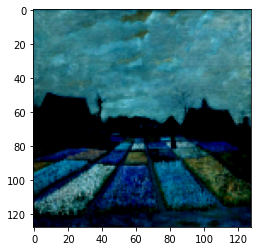

In [84]:
import matplotlib.pylab as plt

plt.imshow(dataset[1].numpy().transpose(1,2,0))